# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started March 2021  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb

In [3]:
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)

<module 'LIM_stats_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_stats_kb.py'>

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.6

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','tos','sic']
limvars_nosic = ['tas','tos']
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True

In [7]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration', 
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

areawt_name = {'tas':'areacella',
               'psl':'areacella',
               'sic':'areacello', 
               'sit':'areacello',
               'tos':'areacello',
               'zg': 'areacella'}

month_names = ['January','Februrary','March','April','May','June','July','August',
               'September','October','November','December']

In [8]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = limkb.build_training_dic(train_dsource)
fdic_mpi = limkb.build_training_dic(valid_dsource)

In [11]:
areacell = {}
areacella_dict = {}
areacell['areacella'], areacella_dict = limkb.load_data('areacella', areacella_dict, fdic_ccsm4, 
                                                  remove_climo=False, detrend=False, verbose=False)

areacello_dict = {}
areacell['areacello'], areacello_dict = limkb.load_data('areacello', areacello_dict, fdic_ccsm4, 
                                                  remove_climo=False, detrend=False, verbose=False)

areacell_dict = {}
areacell_dict['areacello'] = areacello_dict
areacell_dict['areacella'] = areacella_dict

## Compress full fields: 

In [17]:
# load training data...
wt=True
limvars = ['tas']
ntrunc_full = 30
nmodes_sic = 30
var_dict = {}

for k, var in enumerate(limvars): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=True, 
                                      detrend=True, verbose=True)
    
    print('X_var shape: '+str(X_var.shape))
    X_var_mo = np.reshape(X_var,(X_var.shape[0],int(X_var.shape[1]/12),12))
    X_var_ann = np.nanmean(X_var_mo,axis=2)
    print('X_var_ann shape: '+str(X_var_ann.shape))
    
    tsamp = X_var.shape[1]
    
    acell = areacell[areawt_name[var]]
    if len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
    else: 
        acell_1d = acell
     
    [Ptrunc, E3, tot_var,
     tot_var_eig, W_all, 
     standard_factor] = limkb.step1_compress_individual_var(X_var_ann, var, ntrunc_full, nmodes_sic, 
                                                            var_dict, areawt=acell_1d,
                                                            wt=wt, sic_separate=False)

    var_save = {}
    var_save['var_dict'] = var_dict
    var_save['Ptrunc'] = Ptrunc
    var_save['E3'] = E3
    var_save['standard_factor'] = standard_factor
    var_save['W_all'] = W_all
    
    if var =='sic':
        savename = (str(var)+'_ntrunc'+str(nmodes_sic)+'_'+valid_dsource+'_'+today_date+'.pkl')
    else: 
        savename = (str(var)+'_ANNUAL_ntrunc'+str(ntrunc_full)+'_'+valid_dsource+'_'+today_date+'.pkl')
    pickle.dump(var_save, open(savename, "wb" ) )
        
#    del X_var


Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 19.171128511428833 seconds
-----------------------------------------------------
X_var shape: (18432, 12000)
X_var shape: (18432, 1000)
fraction in first 30 tas EOFs = 69.02746253308172


In [25]:
areacell['areacella'].shape

(96, 192)

In [28]:
gm_xvar = statskb.global_mean(X_var_ann, areacell['areacella'])

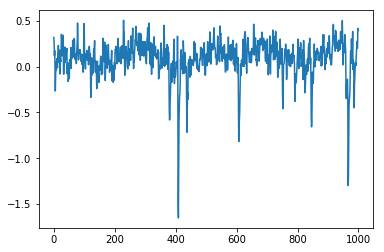

In [29]:
plt.plot(gm_xvar)

### Load compressed raw data: 

In [23]:
mod_folder = 'truncated_model_data/'
mod_filename = '_ntrunc400_mpi_lm_kb_20210406.pkl'
mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210406.pkl'

def load_truncated_data(var, mod_folder, mod_filename):
    print('Loading truncated '+var)
    mod_data = pickle.load(open(mod_folder+var+mod_filename, "rb" ) )

    var_dict = mod_data['var_dict']
    X_var_trunc = mod_data['Ptrunc']
    X_var_E3 = mod_data['E3']
    X_var_standard_factor = mod_data['standard_factor']
    X_var_W_all= mod_data['W_all']
    
    return X_var_trunc, var_dict, X_var_E3, X_var_standard_factor, X_var_W_all

## Build L from scratch: 

In [26]:
# load training data...
load = 'truncated'

wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
E3 = {}
Ptrunc = {}
standard_factor = {}

tot_var_valid = {}
tot_var_eig_valid = {}
W_all_valid = {}
E3_valid = {}
Ptrunc_valid = {}
standard_factor_valid = {}

# X_var_E3 = {}
# X_var_standard_factor = {}
# X_var_W_all = {}

#n=0

for k, var in enumerate(limvars): 
    
    if load == 'full':
        X_var, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=True, 
                                          detrend=True, verbose=True)
    elif load == 'truncated': 
        if var == 'sic':
            mod_fname = mod_sic_filename
            print('Using '+var+mod_fname)
        else: 
            mod_fname = mod_filename
            print('Using '+var+mod_fname)
            
        [X_var, var_dict, E3[var], standard_factor[var], 
         W_all[var]] = load_truncated_data(var, mod_folder, mod_fname)
        print(X_var.shape)

    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)

    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    
    X_train = X_t[:,0:nyears_train,mo:mo+2]
    X_train_2d = np.reshape(X_train,(X_train.shape[0],nyears_train*2))
    ntime = X_train.shape[1]

    X_valid = X_t[:,nyears_train:,mo]
    
    acell = areacell[areawt_name[var]]
    if len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
    else: 
        acell_1d = acell
        
    
    if load == 'full':
        [Ptrunc[var], E3[var], tot_var[var],
         tot_var_eig[var], W_all[var], 
         standard_factor[var]] = limkb.step1_compress_individual_var(X_train_2d, var, ntrunc, nmodes_sic, 
                                                                     var_dict, areawt=acell_1d,
                                                                     wt=wt, sic_separate=sic_separate)
        
    elif load == 'truncated':
        Ptrunc[var] = X_train_2d 
        Ptrunc_valid[var] = X_valid

    
#     [Ptrunc_valid[var], E3_valid[var], tot_var_valid[var],
#      tot_var_eig_valid[var],W_all_valid[var],
#      standard_factor_valid[var]] = limkb.step1_compress_individual_var(X_valid, var,ntrunc, nmodes_sic, 
#                                                                        var_dict, areawt=acell_1d,wt=wt, 
#                                                                        sic_separate=sic_separate)
#     for m in range(12):
#         X_valid = X_t[:,nyears_train:,m]
        
#         [Ptrunc_valid, E3_valid, tot_var_valid,
#         tot_var_eig_valid, W_all_valid] = step1_compress_individual_var(X_valid, ntrunc, nmodes_sic, var_dict, n, 
#                                                                         areawt=areacell[areawt_name[var]],
#                                                                         wt=wt, sic_separate=sic_separate)
#         Ptrunc_valid_var[:,:,m] = Ptrunc_valid[var]
#         E3_valid_var[:,:,m] = E3_valid[var]
        
    
    del X_var

Using tas_ntrunc400_mpi_lm_kb_20210406.pkl
Loading truncated tas
(400, 12000)
Using tos_ntrunc400_mpi_lm_kb_20210406.pkl
Loading truncated tos
(400, 12000)
Using sic_ntrunc50_mpi_lm_kb_20210406.pkl
Loading truncated sic
(50, 12000)


In [27]:
 X_t.shape

(50, 1000, 12)

In [28]:
Ptrunc['tas'].shape,Ptrunc['sic'].shape

((400, 1200), (50, 1200))

In [29]:
# Get indices for each variable:
start = 0
for k, var in enumerate(limvars): 
    print('working on '+var)
    inds = var_dict[var]['var_ndof']
    var_inds = np.arange(start,start+inds,1)
    start = inds+start
    
    var_dict[var]['var_inds'] = var_inds

working on tas
working on tos
working on sic


In [30]:
len(limvars)

3

In [31]:
# if load == 'full':
#     ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)
# elif load == 'truncated':
#     if sic_separate is True:
#         ndof_all = ((len(limvars)-1)*ntrunc)
#     else:
#         ndof_all = len(limvars)*ntrunc

ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic, E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                               var_dict, sic_separate=sic_separate)

[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 77.98890582921366
Shape of E: (74752, 60)


In [32]:
Ptrunc_all.shape, P_train.shape, Ptrunc_sic.shape, Ptrunc['sic'].shape

((800, 1200), (110, 1200), (50, 1200), (50, 1200))

In [33]:
ndof_all_valid = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
                                                            E3, var_dict, sic_separate=sic_separate)

[P_train_valid, Fvar_valid, 
 E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
                                              sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 81.65315738574316
Shape of E: (74752, 60)


In [34]:
P_train_valid.shape, P_train.shape

((110, 400), (110, 1200))

In [35]:
# ndof_all_valid = limkb.count_ndof_all(limvars, E3_valid, sic_separate=sic_separate)

# [Ptrunc_all_valid2, E3_all_valid2,
#  Ptrunc_sic_valid2, E_sic_valid2] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc, E3, 
#                                                             var_dict, sic_separate=sic_separate)

# [P_train_valid2, Fvar_valid2, 
#  E_valid2] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic,
#                                               sic_separate=sic_separate)

In [36]:
nmo = int(P_train.shape[1]/nyears_train)
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [80]:
# LIM_save = {}
# LIM_save['LIMd2'] = LIMd2
# LIM_save['var_dict'] = var_dict
# LIM_save['P_train_valid'] = P_train_valid
# LIM_save['P_train'] = P_train
# LIM_save['E'] = E
# LIM_save['E_sic'] = E_sic
# LIM_save['E_valid'] = E_valid
# LIM_save['E_sic_valid'] = E_sic_valid
# LIM_save['W_all'] = W_all
# LIM_save['W_all_valid'] = W_all_valid
# LIM_save['E_valid2'] = E_valid2
# LIM_save['E_sic_valid2'] = E_sic_valid2

# var_nms = [l+'_' for l in limvars]
# savename = ('L_mo'+str(mo)+'_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+
#             '_nmodessic'+str(nmodes_sic)+'_ntrain'+str(nyears_train)+'_040521.pkl')
# pickle.dump(LIM_save, open(savename, "wb" ) )

In [47]:
# run building_L_single_month_040521.py

## Load pre-build L: 

In [25]:
var_nms = [l+'_' for l in limvars]
# savename = ('L_mo'+str(mo)+'_'+''.join(var_nms)+ 'ntrunc'+str(ntrunc)+
#             '_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'_ntrain'+str(nyears_train)+'_032321.pkl')
# folder = 'L_tas_tos_sic_mpilm_ntrunc400_nmodes60_nmodessic_50_ntrain_2000_032321/'

savename = 'L_mo4_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl'
folder = 'L_tas_tos_sic_mpilm_ntrunc400_nmodes60_nmodessic50_ntrain600_20210405/'

LIM_save = pickle.load(open(folder+savename, "rb" ) )

LIMd2 = LIM_save['LIMd2']
var_dict = LIM_save['var_dict']
P_train_valid = LIM_save['P_train_valid'] 
P_train = LIM_save['P_train']
E = LIM_save['E'] 
E_sic = LIM_save['E_sic'] 
E_valid = LIM_save['E_valid']
E_sic_valid = LIM_save['E_sic_valid']
W_all = LIM_save['W_all'] 
W_all_valid = LIM_save['W_all_valid']
# X_valid_mn = LIM_save['X_valid_mn']
# X_train_mn = LIM_save['X_train_mn']

In [20]:
# # Open truncated validation data: 
# var_nms = [l+'_' for l in limvars]
# savename = ('P_train_valid_allmo_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+
#             '_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'_031521.pkl')

# P_save = pickle.load(open(savename, "rb" ) )

# P_train_valid_allmo = P_save['Ptrain_valid_allmo']
# Fvar_valid_allmo = P_save['Fvar_valid_allmo']
# E_valid_allmo = P_save['E_valid_allmo'] 

## Run Forecast: 

In [37]:
P_train.shape

(110, 1200)

In [38]:
P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
P_train_2d.shape

(110, 600, 2)

In [39]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
#lags = [0,1,2,3,4,5,6,7,8,9,10,11]
lags = [0,1,2,3]
#lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

LIM_fcast = limkb.LIM_forecast_Gt(LIMd2,P_train_2d[:,:,0],lags)
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

t= 0
t= 1
t= 2
t= 3


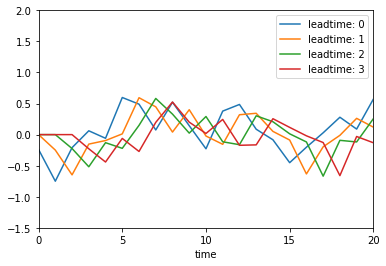

In [16]:
plt.plot(LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(LIM_fcast['x_forecast'][1,0,:], label='leadtime: 1')
plt.plot(LIM_fcast['x_forecast'][2,0,:], label='leadtime: 2')
plt.plot(LIM_fcast['x_forecast'][3,0,:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

In [17]:
LIM_fcast['x_forecast'].shape

(4, 110, 600)

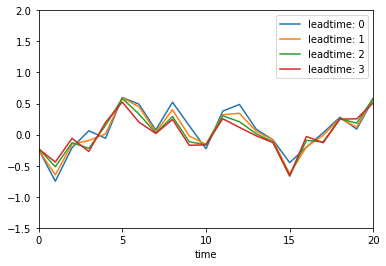

In [18]:
plt.plot(np.arange(0,600,1),LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(np.arange(0,599,1),LIM_fcast['x_forecast'][1,0,1:], label='leadtime: 1')
plt.plot(np.arange(0,598,1),LIM_fcast['x_forecast'][2,0,2:], label='leadtime: 2')
plt.plot(np.arange(0,597,1),LIM_fcast['x_forecast'][3,0,3:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

In [51]:
x_forecast_dcomp = np.zeros((len(lags),E.shape[0]+E_sic.shape[0],
                             LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E,
                                                                E_sic,limvars,var_dict,
                                                                W_all,sic_separate=sic_separate)
    
#units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']                                                           W_all,Weights=True,sic_separate=sic_separate)

Lag 0


ValueError: shapes (56320,400) and (50,600) not aligned: 400 (dim 1) != 50 (dim 0)

In [52]:
LIM_fcast['x_forecast'].shape

(4, 460, 600)

(0, 100)

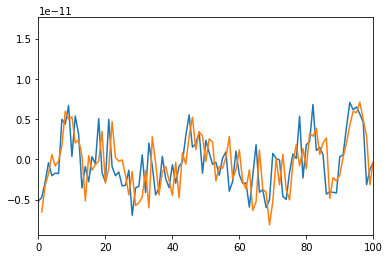

In [20]:
x_test = x_forecast_dcomp[0,var_dict['sic']['var_inds'],:]
x_test1 = x_forecast_dcomp[1,var_dict['sic']['var_inds'],:]

plt.plot(np.arange(0,600,1),x_test[0,:])
plt.plot(np.arange(1,600,1),x_test1[0,1:])
#plt.plot(np.arange(5,400,1),x_test1[0,5:])
plt.xlim(0,100)

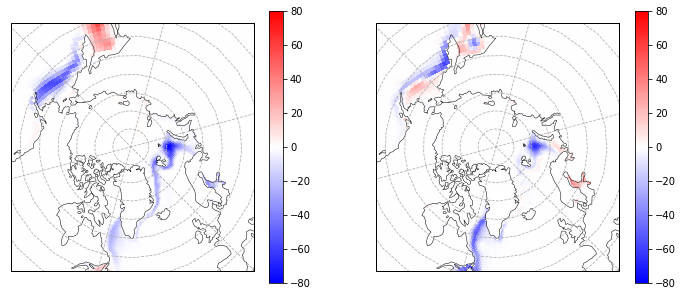

In [21]:
var = 'sic'
x_reshape = np.reshape(x_forecast_dcomp[1,var_dict[var]['var_inds'],:], (220,256,600))
x_reshape2 = np.reshape(x_forecast_dcomp[0,var_dict[var]['var_inds'],:], (220,256,600))

fig,ax = plt.subplots(1,2,figsize=(12,5), subplot_kw=arc_proj )
ax = ax.flatten()

plotkb.sub_arctic_plot(ax[0],fig,x_reshape[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')
plotkb.sub_arctic_plot(ax[1],fig,x_reshape2[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')


In [36]:
tot_nh_sic_truth.shape,tot_nh_sic_forecast.shape

((600,), (599,))

Loading sic
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 61.223856925964355 seconds
-----------------------------------------------------
Lag 0
Using month 0...
Step = 0


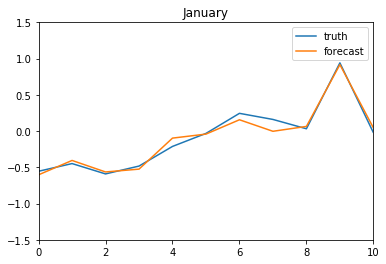

0.6623251432135906
Lag 1
Using month 0...
Step = 1


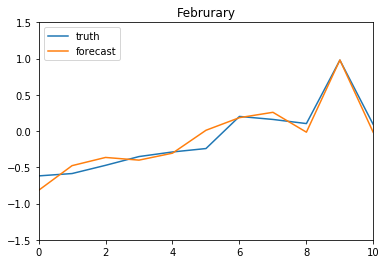

0.5987320507651156
Lag 2
Using month 0...
Step = 2


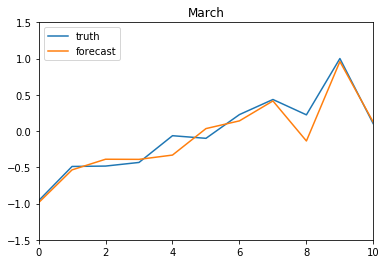

0.5947672885472719
Lag 3
Using month 0...
Step = 3


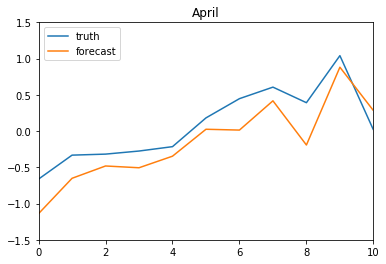

0.7085646750269674


In [18]:
v = {}
validvars = ['sic']
validation_stats = {}
valid_stats = {}

for k, var in enumerate(validvars): 
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))

    X_var, _ = limkb.load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)

    for i,lag in enumerate(lags):
#    for i,lag in enumerate([0]):
        print('Lag '+str(lag))
        
        x_forecast = x_forecast_dcomp[lag,var_dict[var]['var_inds'],:] #+ X_valid_mn[:,np.newaxis]
        x_forecast_new_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
            
        tsamp = X_var.shape[1]
        nyears_train = int((tsamp*ntrain)/12)
        #nyears_valid = int(X_all_mpi.shape[2]/12)
        nyears_valid = nyears_train
        ntime_train = x_forecast.shape[1]
        
        if mo is 'all':
            print('Using all months...')
            X_t = X_var
            X_valid = X_t[:,0:ntime_train]
            
            start_time = lag
            x_truth = X_t[:,start_time:ntime_train]
            x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
            
        else: 
            print('Using month '+str(mo)+'...')
            nyears_train = x_forecast.shape[1]
            #nyears_valid = int(X_all_mpi.shape[2]/12)
            nyears_valid = nyears_train

            X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
            X_valid = X_t[:,0:nyears_train:,mo]
    #    truth = X_t[:,nyears_train:,mo+1]
         
            step = mo+lag
            print('Step = '+str(step))
            if step>11:
                step = step-12
                start_yr = 1
            else: 
                start_yr = 0
            
            x_truth = X_t[:,start_yr:nyears_train-lag,step]
            x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
                    
        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_new_anom, areacell[areawt_name[var]], 
                                          units, var_dict[var]['lat'], lat_cutoff=0.0)
        tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                                       units, var_dict[var]['lat'],lat_cutoff=0.0)
        
        plt.figure(figsize=(6,4))
        plt.plot(tot_nh_sic_truth*1e-6,label='truth')
        plt.plot(tot_nh_sic_forecast*1e-6,label='forecast')
        plt.xlim(0,10)
        plt.ylim(-1.5, 1.5)
        if mo is 'all':
            plt.title('All months')
        else:
            plt.title(month_names[step])
        plt.legend()
        plt.show()
        
#         if lag ==0: 
        corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
        ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

        error_var = np.nanvar(x_truth_anom-x_forecast_new_anom,axis=1,ddof=1)
        truth_error_var = np.nanvar(x_truth_anom,axis=1,ddof=1)
#         else: 
#             corr_tot[i] = np.corrcoef(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])[0,1]
#             ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])

#             error_var = np.nanvar(x_truth_anom[:,:-lag]-x_forecast_new_anom[:,lag:],axis=1,ddof=1)
#             truth_error_var = np.nanvar(x_truth_anom[:,:-lag],axis=1,ddof=1)
            
        gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
        gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[i]=gm_error_var/gm_truth_var
        
        print(np.var([1060,:]))
    valid_stats['gm_var_ratio'] = gm_var_ratio
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

Lag 0
step = 1


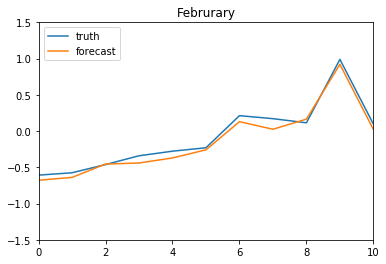

0.6915273209298033
Lag 1
step = 2


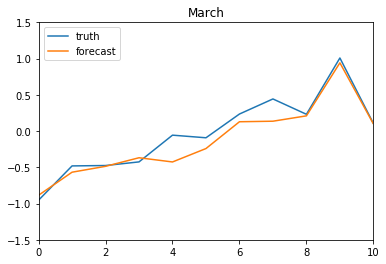

0.5179394497050321
Lag 2
step = 3


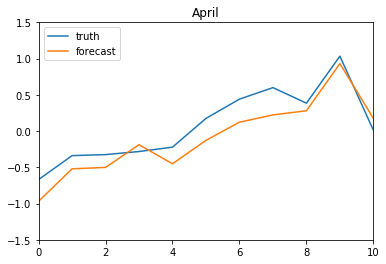

0.4339224782905609
Lag 3
step = 4


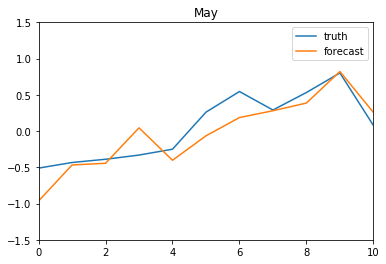

0.41723969861999805


In [66]:
v = {}
validvars = ['sic']
validation_stats = {}
valid_stats = {}

for k, var in enumerate(validvars): 
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))

#    X_var, _ = limkb.load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    mo = 1
    for i,lag in enumerate(lags):
#    for i,lag in enumerate([0]):
        print('Lag '+str(lag))
        
        x_forecast = x_forecast_dcomp[lag,var_dict[var]['var_inds'],:] #+ X_valid_mn[:,np.newaxis]
        
        tsamp = X_var.shape[1]
#        nyears_train = int((tsamp*ntrain)/12)
#         nyears_valid = int((tsamp*(1-ntrain))/12)
        nyears_train = x_forecast.shape[1]
        nyears_valid = nyears_train

        X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
        
        step = mo+lag
        print('step = '+str(step))
        if step>11:
            step = step-12
            start_yr = 0+1
        else: 
            start_yr = 0
            
        x_truth = X_t[:,start_yr:nyears_train,step]
        x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
        
#         if var is 'sic':
#             x_forecast_noneg = np.where(x_forecast<-100.0, -100.0, x_forecast)
#             x_forecast_new = np.where(x_forecast_noneg>100.0, 100.0, x_forecast_noneg)
#         else: 
#             x_forecast_new = x_forecast
        x_forecast_new_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
    
        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_new_anom, areacell[areawt_name[var]], 
                                          units, var_dict[var]['lat'], lat_cutoff=0.0)
        tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                                       units, var_dict[var]['lat'],lat_cutoff=0.0)
        
        plt.figure(figsize=(6,4))
        plt.plot(tot_nh_sic_truth*1e-6,label='truth')
        plt.plot(tot_nh_sic_forecast*1e-6,label='forecast')
        plt.xlim(0,10)
        plt.ylim(-1.5,1.5)
        plt.legend()
        plt.title(month_names[step])
        plt.show()
        
        if lag ==0: 
            corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
            ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

            error_var = np.nanvar(x_truth_anom-x_forecast_new_anom,axis=1,ddof=1)
            truth_error_var = np.nanvar(x_truth_anom,axis=1,ddof=1)
        else: 
            corr_tot[i] = np.corrcoef(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast)[0,1]
            ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast)

            error_var = np.nanvar(x_truth_anom[:,:-lag]-x_forecast_new_anom,axis=1,ddof=1)
            truth_error_var = np.nanvar(x_truth_anom[:,:-lag],axis=1,ddof=1)
            
        gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
        gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[i]=gm_error_var/gm_truth_var
        
        print(np.var(x_forecast_new_anom[1060,:]))
    valid_stats['gm_var_ratio'] = gm_var_ratio
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

In [69]:
x_truth.shape

(56320, 600)

(0, 10)

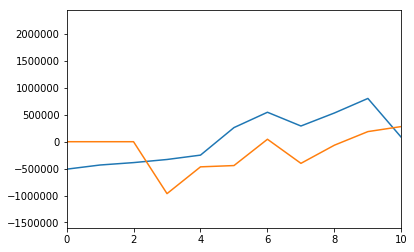

In [54]:
plt.plot(tot_nh_sic_truth)
plt.plot(tot_nh_sic_forecast)
plt.xlim(0,10)

### ^^^ Variance is not decreasing with lag at this and other gridcells? ^^^

In [174]:
start_yr, nyears_train, step

(0, 600, 4)

(0, 10)

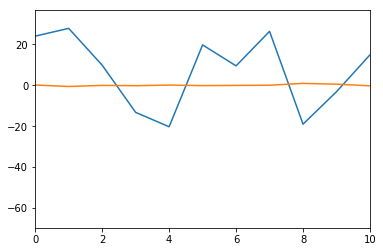

In [44]:
plt.plot(x_truth_anom[1061,:])
plt.plot(x_forecast_new_anom[1061,:])
plt.xlim(0,10)

In [40]:
x_var = x_truth
var_nans_mask = np.where(np.isnan(x_var),np.nan,1)
var_dt = spy.signal.detrend(np.where(np.isnan(x_var),0,x_var),axis=0)
x_var_dt = var_dt*var_nans_mask


In [195]:
testmn = np.nanmean(x_var_dt, axis=1)
testmn[1061]

39.180308591524756

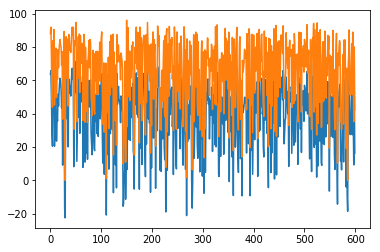

In [196]:
plt.plot(x_var_dt[1061,:])
plt.plot(x_var[1061,:])

Text(0.5,1,'Error Variance: SIC')

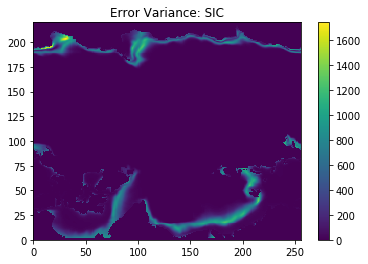

In [41]:
error_sic_2d = np.reshape(error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Error Variance: SIC')

Text(0.5,1,'Truth Variance: SIC')

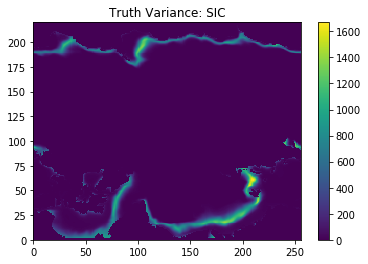

In [42]:
error_sic_2d = np.reshape(truth_error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Truth Variance: SIC')

Text(0,0.5,'GM ratio: error variance to true variance')

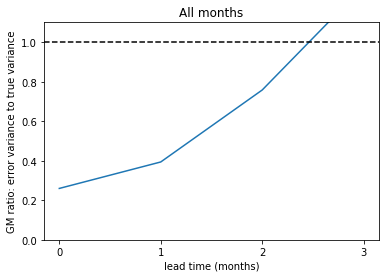

In [39]:
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')
plt.xticks([0,1,2,3])
plt.ylim(0,1.1)
plt.xlabel('lead time (months)')
plt.title('All months')
plt.ylabel('GM ratio: error variance to true variance')

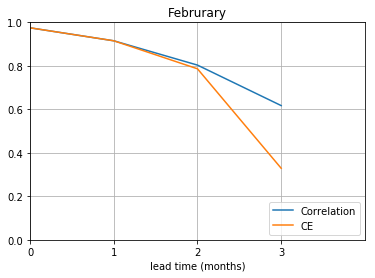

In [40]:
plt.plot(valid_stats['corr_tot']**2, label='Correlation')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.xticks([0,1,2,3])
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])
plt.legend(loc='lower right')

In [24]:
P_train.shape

(110, 1200)

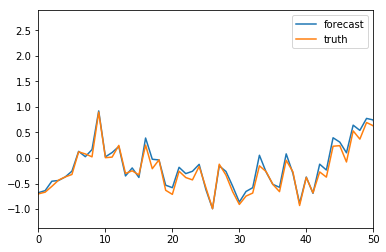

In [190]:
plt.plot(tot_nh_sic_forecast*1e-6, label='forecast')
plt.plot((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6, label='truth')
#plt.plot(tot_nh_sic_forecast[3:]*1e-6, label='forecast')
plt.xlim(0,50)
plt.legend()

In [168]:
np.var((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6), np.var(tot_nh_sic_forecast[1:]*1e-6)

(0.2160661, 0.3710165766249174)

In [79]:
test = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
test

0.886756258791682

In [108]:
# validvars = ['sic']
# v = {}

# for k, var in enumerate(validvars): 
#     X_var, _ = load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
#     mo = 1
#     tsamp = X_var.shape[1]
#     nyears_train = int((tsamp*ntrain)/12)
#     nyears_valid = int((tsamp*(1-ntrain))/12)

#     X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
#     x_truth = X_t[:,nyears_train:,mo+1]
    
#     x_forecast = x_forecast_dcomp[var_dict[var]['var_inds'],:]
    
#     units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
#     tot_nh_sic_forecast = calc_tot_si(x_forecast, areacell[areawt_name[var]], 
#                                       units, var_dict[var]['lat'], cutoff=0.0)
#     tot_nh_sic_truth = calc_tot_si(x_truth, areacell[areawt_name[var]], 
#                                    units, var_dict[var]['lat'],cutoff=0.0)
    
#     corr_tot_sic = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
#     ce_tot_sic = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)
    
#     error_var = np.nanvar(x_forecast - x_truth,axis=1,ddof=1)
#     gm_error_var = global_mean(error_var,areacell[areawt_name[var]])
    
#     truth_error_var = np.nanvar(x_truth,axis=1,ddof=1)
#     gm_truth_var = global_mean(truth_error_var,areacell[areawt_name[var]])

Loading sic
-----------------------------------------------------
completed in 86.63140058517456 seconds
-----------------------------------------------------


In [64]:
validation_stats['sic']['gm_var_ratio'].shape, validation_stats['sic']['corr_tot'].shape, validation_stats['sic']['ce_tot'].shape

((12,), (12, 400), (12, 400))

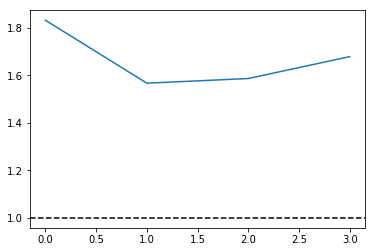

In [51]:
plt.plot(validation_stats['sic']['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')

Text(0.5,1,'Februrary')

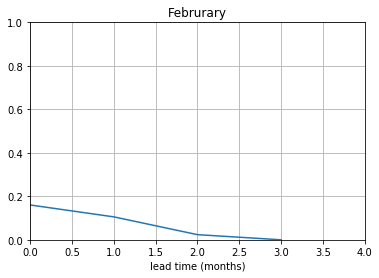

In [52]:
plt.plot(validation_stats['sic']['corr_tot']**2, label='Correlation')
plt.plot(validation_stats['sic']['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])

In [54]:
validation_stats['sic']['corr_tot'], validation_stats['sic']['ce_tot']

(array([0.40027682, 0.32482808, 0.153841  , 0.00142255]),
 array([-0.28152417, -0.15181716, -0.48757427, -1.16456038]))

In [51]:
validation_stats['sic'].keys()

dict_keys(['gm_var_ratio', 'corr_tot', 'ce_tot'])

In [57]:
validation_stats['sic']['corr_tot'].shape

(12, 400)

In [ ]:
LIMd['G']**t

In [26]:
def arctic_mean(var, areacell, cutoff=0.0): 
    tot_nh_var = var*areacell
    if len(lat.shape)<=1:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds,:],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds,:],axis=0),axis=0)
    else:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds],axis=0),axis=0)
    
    var_mn = tot_nh_var/wt_sum
    
    return var_mn

In [27]:
def global_mean(var, areacell): 
    """Assumes var is dimensions (nlat*nlon,time)
    """
    
    tot_nh_var = var*areacell
    
    tot_var = np.nansum(tot_nh_var,axis=0)
    wt_sum = np.nansum(areacell,axis=0)
    
    var_mn = tot_var/wt_sum
    
    return var_mn

In [28]:
def calc_tot_si(var, areacell, units, lat, cutoff=0.0): 
    if units == 'm2':
        cellarea = (areacell*1e-6)[:,np.newaxis]
    else: 
        cellarea = areacell[:,np.newaxis]
        
    if var.max()>2:
        Var = var/100.0
    else: 
        Var = var
        
    nh_var = Var*cellarea
    
    if len(lat.shape)<=1:
        lat_inds = np.where(lat>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    else:
        lat_1d = np.reshape(lat,(var.shape[0]))
        lat_inds = np.where(lat_1d>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    
    return tot_nh_var
    

In [29]:
def calc_gm_polar_variance(valid_var,valid_var_mon,fields,lat,lon):
    valid_variance = {}
    gm_mon = np.zeros((12))
    polar_mon = np.zeros((2,12))
    nlat = lat.shape[0]
    nlon = lon.shape[0]

    for v in fields.keys():
        print(v)
        var = np.reshape(valid_var[fields[v]],[nlat,nlon])
        var_mon = np.reshape(valid_var_mon[fields[v],:].T,[12,nlat,nlon])

        gm,_,_ = LMR_utils.global_hemispheric_means(var,lat)
        polar = polar_regional_means(var,lat,lon)
        polar_mon = polar_regional_means(var_mon,lat,lon)
        for m in range(12):
            gm_mon[m],_,_ = LMR_utils.global_hemispheric_means(var_mon[m,:,:],lat)

        valid_variance[v+'_gm'] = gm
        valid_variance[v+'_gm_mon'] = gm_mon
        valid_variance[v+'_polarm'] = polar
        valid_variance[v+'_polarm_mon'] = polar_mon
        
    return valid_variance

In [30]:
def LIM_forecast(LIMd,x,lags):
    """
    # There is a bug with this forecast function function: It uses the eigenvectors and 
    #        values to calculate Gt, but it's giving the same value for all lags in the forecast
    
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    LIMfd = {}
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    for k,t in enumerate(lags):
        print('t=',t)
        # make the propagator for this lead time
 #       Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,t:] = x_predict

        # physical-space fields for forecast and truth for this forecast lead time ~(ndof,ntims)
#        X_predict = np.real(np.matmul(E,x_predict))
        #X_truth = np.real(np.matmul(E,x[:,t:]))
#         X_truth = truth[:,t:]
        
#         # error variance as a function of space and forecast lead time ~(ndof,ntims)
#         error[:,k] = np.var(X_predict - X_truth,axis=1,ddof=1)
    
        # return the LIM forecast error dictionary
#         LIMfd['error'] = error
        Ld = {}
        Ld['Gt'] = Gt
        LIMfd[t] = Ld
    
    LIMfd['x_forecast'] = np.squeeze(x_predict_save)    
        
    return LIMfd

In [31]:
def LIM_forecast_Gt(LIMd,x,lags):
    """
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    LIMfd = {}
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    for k,t in enumerate(lags):
        print('t=',t)
        # make the propagator for this lead time
 #       Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        Gt = np.linalg.matrix_power(LIMd['G'],t)
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,t:] = x_predict

        Ld = {}
        Ld['Gt'] = Gt
        LIMfd[t] = Ld
    
    LIMfd['x_forecast'] = np.squeeze(x_predict_save)    
        
    return LIMfd

In [ ]:
yrs_mo = np.reshape(var_dict[var]['time'],(int(tsamp/12),12))

yrs_train = yrs_mo[0:nyears_train,mo]
yrs_valid = yrs_mo[nyears_train:,mo+1]

## EOF decomposition: 

In [ ]:
[Ptrunc, E3, Ptrunc_sic, E_sic,
 W_train, sf_train,
 tot_var, tot_var_eig] = limkb.step1_compress_individual_vars(X_train, limvars, ntrunc, 
                                                              nmodes_sic, var_dict,X_all.shape[0],
                                                              var_dict['sic']['var_ndof'], 
                                                              wt=True,sic_separate=sic_separate)


[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc,nmodes, E3, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

In [ ]:
[Ptrunc2, E3_2, Ptrunc_sic2, 
 E_sic2, W_train2, sf_train2] = limkb.compress_individual_vars2(X_train2, limvars, ntrunc, nmodes_sic, var_dict, 
                                                                X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                                sic_separate=sic_separate)
    
[P_train2, Fvar2, E2] = limkb.step2_multivariate_compress(Ptrunc2,nmodes, E3_2, 
                                                          Ptrunc_sic2, sic_separate=sic_separate)

In [ ]:
[Ptrunc_valid, E3_valid, Ptrunc_sic_valid, 
 E_sic_valid, W_valid, sf_valid] = limkb.compress_individual_vars2(X_valid, limvars, ntrunc, nmodes_sic, 
                                                                   var_dict,X_all.shape[0], 
                                                                   var_dict['sic']['var_ndof'], 
                                                                   sic_separate=sic_separate)

[P_valid, Fvar_valid, E_valid] = limkb.step2_multivariate_compress(Ptrunc_vlaid,nmodes, E3_valid, 
                                                                   Ptrunc_sic_valid, sic_separate=sic_separate)

In [195]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X_all.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train
x_train2 = P_train2
x_valid = P_valid

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 600)
validation data shape:  (60, 400)


In [ ]:
# x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
#                                              limvars,var_dict,W_train,Weights=True,
#                                              sic_separate=sic_separate)

In [196]:
# # climo standardized variance for error normalization 
# #  in training and validation (1=no skill)
# # EOF space only
# if sic_separate is True: 
#     E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
#     E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E_valid,E_sic_valid)

# else: 
#     E_x_train = np.matmul(E,x_train)
#     E_x_valid = np.matmul(E_valid,x_valid)

# E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
# E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
# nyrs_train = int(E_x_train.shape[1]/12)
# nyrs_valid = int(E_x_valid.shape[1]/12)
# nlalo = E_x_train.shape[0]

# # train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
# #                        axis=1,ddof=1)
# # valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
# #                        axis=1,ddof=1)
# train_var = np.nanvar(E_x_train,axis=1,ddof=1)
# valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# # FULL FIELD versions of the variance 
# train_var_full = np.nanvar(X_train,axis=1,ddof=1)
# valid_var_full = np.nanvar(X_valid,axis=1,ddof=1)

# # valid_var_mon_full = np.var(np.reshape(X_mpi,(nvars*ndof,nyrs_valid,12)),
# #                             axis=1,ddof=1)

In [49]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [51]:
LIMd2, G2 = lim.LIM_train_flex(tau,x_train, x_train2)

In [52]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E_valid,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic_valid,
                                    sic_separate=sic_separate)

t= 1


ValueError: could not broadcast input array from shape (149504) into shape (225280)

In [141]:
truth_state = {}
nlat = lat_2d[:,0].shape[0]
nlon = lon_2d[0,:].shape[0]

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        Truth = lim.decompress_eof(truth,E,E_sic=E_sic,
                                   nmodes=nmodes,nmodes_sic=nmodes_sic,
                                   sic_separate=sic_separate)
    else: 
        Truth = np.matmul(E,truth)
#            print(Truth.shape)
    truth_3d = np.reshape(Truth[fields[var],:].T,[Truth.shape[1],nlat,nlon])
    truth_gm,_,_ = LMR_utils.global_hemispheric_means(truth_3d[1:,:,:],lat_2d[:,0])
    truth_pm = lim.polar_regional_means(truth_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    truth_state[var+'_gm_mo_'+str(mo)] = truth_gm
    truth_state[var+'_pm_mo_'+str(mo)] = truth_pm
    truth_state[var+'_full_mo_'+str(mo)] = truth_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [142]:
LIMfd_valid['x_forecast'].shape

(1, 120, 1000)

In [143]:
forecast = {}

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        fcast = lim.decompress_eof(LIMfd_valid['x_forecast'][0,:,:],E,E_sic=E_sic,
                                      nmodes=nmodes,nmodes_sic=nmodes_sic,
                                      sic_separate=sic_separate)
    else: 
        fcast = np.matmul(E,LIMfd_valid['x_forecast'][0,:,:])
#            print(Truth.shape)
    forecast_3d = np.reshape(fcast[fields[var],:].T,[fcast.shape[1],nlat,nlon])
    forecast_gm,_,_ = LMR_utils.global_hemispheric_means(forecast_3d[1:,:,:],lat_2d[:,0])
    forecast_pm = lim.polar_regional_means(forecast_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    forecast[var+'_gm_mo_'+str(mo)] = forecast_gm
    forecast[var+'_pm_mo_'+str(mo)] = forecast_pm
    forecast[var+'_full_mo_'+str(mo)] = forecast_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [144]:
ce = {}
corr = {}

for n,var in enumerate(limvars):
    print('working on '+str(var))
    ce_pm_lag = np.zeros((2))
    corr_pm_lag = np.zeros((2))

    ce_gm = LMR_utils.coefficient_efficiency(truth_state[var+'_gm_mo_'+str(mo)],
                                                    forecast[var+'_gm_mo_'+str(mo)])
    corr_gm = np.corrcoef(truth_state[var+'_gm_mo_'+str(mo)],
                                 forecast[var+'_gm_mo_'+str(mo)])[0,1]

    for n in range(2):
        ce_pm_lag[n] = LMR_utils.coefficient_efficiency(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                                          forecast[var+'_pm_mo_'+str(mo)][n,:])
        corr_pm_lag[n] = np.corrcoef(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                       forecast[var+'_pm_mo_'+str(mo)][n,:])[0,1]

    ce[var+'_gm_mo_'+str(mo)] = ce_gm
    ce[var+'_pm_mo_'+str(mo)] = ce_pm_lag
    corr[var+'_gm_mo_'+str(mo)] = corr_gm
    corr[var+'_pm_mo_'+str(mo)] = corr_pm_lag

working on tas
working on psl
working on tos
working on sit
working on sic


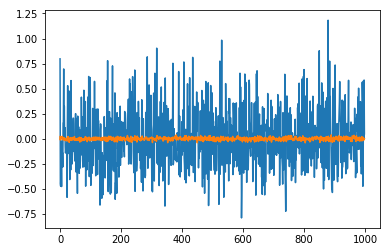

In [148]:
plt.plot(forecast['tas_gm_mo_'+str(mo)])
plt.plot(truth_state['tas_gm_mo_'+str(mo)])

In [145]:
for var in limvars: 
    print(var)
    print('GM CE = '+str(ce[var+'_gm_mo_'+str(mo)])+' GM Corr = '+ str(corr[var+'_gm_mo_'+str(mo)]))

tas
GM CE = -403.25880941645715 GM Corr = -0.024220206464738832
psl
GM CE = -741.4342540101476 GM Corr = -0.055287853100057884
tos
GM CE = -264.07100597064516 GM Corr = -0.03161414428771794
sit
GM CE = -342.94229872323535 GM Corr = -0.04336836101191847
sic
GM CE = -17.072935880843577 GM Corr = -0.019626058348466802


In [38]:
ce_ar1, corr_ar1= lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                           lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [39]:
ce_ar1_valid, corr_ar1_valid = lim.calc_ce_corr_ar_lags(X_valid,X_valid,lags,
                                                        limvars,lat_2d[:,0], lon_2d[0,:])

working on tas
working on psl
working on tos


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:797: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


working on sic


In [ ]:
X_valid.shape

In [ ]:
Xv.shape

In [112]:
v = 3
var = 'tos'
Xt = X_valid
Xv = X_valid
lat = lat_2d[:,0]
lon = lon_2d[0,:]
l = np.arange(1,2,1)

ar1_gm = np.zeros((len(l),Xv.shape[2]))
ar1_pm = np.zeros((len(l),2,Xv.shape[2]))
ce_pm = np.zeros((len(l),2))
corr_pm = np.zeros((len(l),2))

for i,lag in enumerate(l):
    ar1_forecast, ar1_factor = lim.red_noise_forecast_ar1(Xt[v,:].T,Xv[v,:].T,lead=lag)
    ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
    X_valid_3d = np.reshape(Xv[v,:].T,(Xv.shape[2],nlat,nlon))
    ar1_gm[i,lag:],_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
    ar1_pm[i,:,lag:] = lim.polar_regional_means(ar1_forecast_3d,lat,lon)

    true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)
    true_pm = lim.polar_regional_means(X_valid_3d,lat,lon)

    ce_gm = LMR_utils.coefficient_efficiency(true_gm[lag:],ar1_gm[i,lag:])
    corr_gm = np.corrcoef(true_gm[lag:],ar1_gm[i,lag:])[0,1]
    for n in range(2):
        ce_pm[i,n] = LMR_utils.coefficient_efficiency(true_pm[n,lag:],ar1_pm[i,n,lag:])
        corr_pm[i,n] = np.corrcoef(true_pm[n,lag:],ar1_pm[i,n,lag:])[0,1]

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:793: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


In [122]:
np.nanmin(ar1_factor), Xv[v,:].T.shape

(-0.00033366700033366306, (12000, 3240))

In [125]:
ar1_forecast.shape

(11999, 3240)

In [106]:
corr_gm

0.9848644683160668

In [110]:
np.corrcoef(true_gm[1:],ar1_gm[0,1:])[0,1]

0.9848644683160668

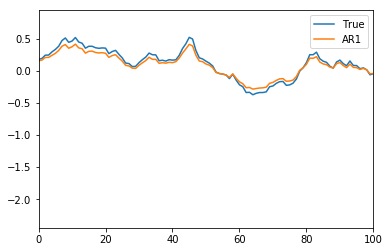

In [108]:
plt.plot(true_gm[1:], label='True')
plt.plot(ar1_gm[0,2:], label='AR1')
plt.xlim(0,100)
plt.legend()

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

In [148]:
corr_ar1_valid['tos_gm']

array([0.        , 0.98486447, 0.96391541, 0.93804171, 0.90800665,
       0.87682375, 0.84661718, 0.81847671, 0.79224612, 0.76764925,
       0.74339473, 0.71778917, 0.69008076])

## Detrending: 

In [12]:
var = 'sic'
wt=True
var_dict = {}

X_var_dt, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=False, 
                                     detrend=True, verbose=True)

Loading sic
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 122.32102942466736 seconds
-----------------------------------------------------


In [16]:
timei = np.arange(0,var_dict['tas']['time'].shape[0])

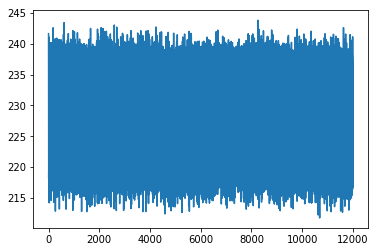

In [17]:
plt.plot(X_var[0,:])

In [ ]:
from scipy import stats 

gradient, intercept, r_value, p_value, std_err = stats.linregress(timei,X_var)

In [19]:
gradient.shape, intercept.shape

(-2.964682750653527e-05, 225.63811699611765)

In [ ]:
var = np.var(X_var[0,:])
var

In [ ]:
Y_anom = X_var - X_var.mean(axis=1)[:,np.newaxis]
X_anom = timei - timei.mean()
X_anom_mat = (X_anom * np.ones_like(Y_anom))

cov = np.dot(X_anom_mat.T,Y_anom)/(len(Y_anom)-1)
var = np.var(timei)

# a = cov/var
# b = X_var[0,:].mean() - (a)*timei.mean()

In [59]:
cov.shape

array([[-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       ...,
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5]])

In [13]:
def calc_linear_fit(X,Y):
    X_anom = X - X.mean()
    Y_anom = Y - Y.mean()
    
    cov = np.dot(X_anom, Y_anom)/(len(Y_anom)-1)
    var = np.var(X)
    
    slope = cov/var
    intercept = Y.mean() - slope*X.mean()
    
    return slope, intercept 

In [14]:
def linear_detrend(X,Y,remove_mn=False):
    slope, intercept = calc_linear_fit(X,Y)
    
    lin_fit = X*slope + intercept 
    
    Y_dt = Y - lin_fit
    
    if remove_mn is False: 
        Y_dt_out = Y_dt + intercept
    else: 
        Y_dt_out = Y_dt 
        
    return Y_dt_out, slope, intercept 

In [30]:
def multi_linear_detrend(X,Y,axis=1,remove_mn=False):
    """
    axis = dimension which to detrend over. 
    """
    if len(Y.shape)>2:
        raise ValueError('Too many dimensions in Y.')
    elif len(Y.shape)<2:
        Y_dt_out, slopes, intercepts = linear_detrend(X,Y,remove_mn=remove_mn)
        
        return Y_dt_out, slopes, intercepts 
    else: 
        Y_dt_out = np.zeros_like(Y)
        slopes = np.zeros(Y.shape[0])
        intercepts = np.zeros(Y.shape[0])
        
        if axis==1: 
            dt_axis=0
        else: 
            dt_axis=1

        for i in range(Y.shape[dt_axis]):
            Y_dt_out[i,:], slopes[i], intercepts[i] = linear_detrend(X,Y[i,:],remove_mn=remove_mn)
            
        return Y_dt_out, slopes, intercepts

In [24]:
Y_dt_out, slope, intercept = multi_linear_detrend(timei,X_var,axis=1,remove_mn=False)

NameError: name 'timei' is not defined

In [25]:
var_dict[var]['time'].shape[0]

12000

In [31]:
var_nans_mask = np.where(np.isnan(X_var),np.nan,1)
Y = np.where(np.isnan(X_var),0,X_var)
X = np.arange(0,var_dict[var]['time'].shape[0],1)
[var_dt,slopes,intercepts] = multi_linear_detrend(X,Y,axis=1,remove_mn=False)
x_var_dt = var_dt*var_nans_mask

In [13]:
t = 1060

slopes[t]

NameError: name 'slopes' is not defined

(11900, 12000)

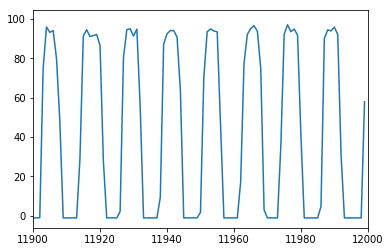

In [17]:
#plt.plot(X_var[t,:])
#plt.plot(X*slopes[t]+intercepts[t])
#plt.plot(x_var_dt[t])
plt.plot(X_var_dt[t])
plt.xlim(11900,12000)

(11900, 12000)

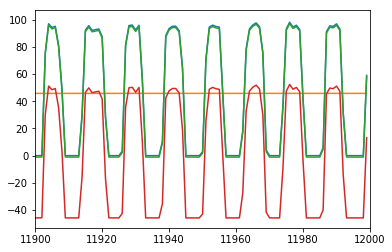

In [40]:
plt.plot(X_var[t,:])
plt.plot(X*slopes[t]+intercepts[t])
plt.plot(x_var_dt[t])
plt.plot(X_var_dt[t])
plt.xlim(11900,12000)

In [45]:
(slopes)

array([0., 0., 0., ..., 0., 0., 0.])

(0, 20)

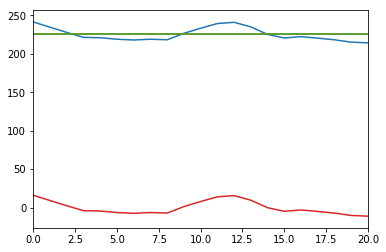

In [45]:
plt.plot(X_var[0,:])
plt.plot(timei*a+b)
plt.plot(timei*gradient+intercept)
plt.plot(Y_dt_out)
plt.xlim(0,20)

(0, 20)

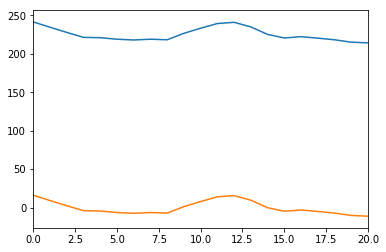

In [38]:
plt.plot(X_var[0,:])
plt.plot(Y_dt_out)
plt.xlim(0,20)